In [19]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiplicativeLR
from torchvision import transforms
import torch.optim as optim

from tqdm import tqdm

from time import sleep

from collections import OrderedDict, defaultdict 

import warnings
warnings.filterwarnings('ignore')

In [2]:
GPU = True
device = "cuda" if GPU and torch.cuda.is_available() else "cpu"

print(f'Using device {device}')

Using device cuda


In [3]:
os.listdir('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/')[:5]

['TCGA_DU_6404_19850629_41.tif',
 'TCGA_DU_6404_19850629_40_mask.tif',
 'TCGA_DU_6404_19850629_18_mask.tif',
 'TCGA_DU_6404_19850629_48.tif',
 'TCGA_DU_6404_19850629_45.tif']

In [4]:
dirr = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

image_size = 256

data = []

for sub_dir_path in glob.glob(dirr + "*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data.extend([dirname, image_path])
        
        
df = pd.DataFrame(
    {
        "dirname" : data[::2],
        "path" : data[1::2]
    }
)

df.head()

,dirname,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df.loc[0, 'path']

'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif'

In [7]:
df.loc[0, 'path'].split('.')[0].split('_')[-1]

'45'

In [8]:
df.loc[1, 'path']

'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif'

In [9]:
df.loc[1, 'path'].split('.')[0].split('_')[-2]

'56'

In [10]:
df_no_masks = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

no_masks = sorted(df_no_masks["path"].values, key=lambda string: int(string.split('.')[0].split('_')[-1]))
masks = sorted(df_masks["path"].values, key=lambda string: int(string.split('.')[0].split('_')[-2]))

In [11]:
df_no_masks.head()

,dirname,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
5,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [12]:
df = pd.DataFrame(
    {
        'patient': df_no_masks['dirname'].values,
        'image_path': no_masks,
        'mask_path': masks
    }
)

In [13]:
df.head()

,patient,image_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [14]:
df.loc[0, 'image_path']

'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif'

In [15]:
df.loc[0, 'mask_path']

'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif'

In [20]:
diagnos = lambda path: 1 if np.max(cv2.imread(path)) > 0 else 0

df["diagnosis"] = df["mask_path"].apply(diagnos)

In [21]:
df.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [22]:
df['diagnosis'].value_counts() / df.shape[0]

0    0.650547
1    0.349453
Name: diagnosis, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, stratify=df['diagnosis'], test_size=0.15, random_state=42)
X_train, X_valid = train_test_split(X_train, stratify=X_train['diagnosis'], test_size=0.15, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

print(X_train['diagnosis'].value_counts() / X_train.shape[0])
print(X_valid['diagnosis'].value_counts() / X_valid.shape[0])
print(X_test['diagnosis'].value_counts() / X_test.shape[0])

0    0.650458
1    0.349542
Name: diagnosis, dtype: float64
0    0.650699
1    0.349301
Name: diagnosis, dtype: float64
0    0.650847
1    0.349153
Name: diagnosis, dtype: float64


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
import random
class MRISegmantation(Dataset):
    def __init__(self, dataframe, transforms):
        
        self.dataframe = dataframe
        self.transforms = transforms
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
#         
        
        image = Image.open(self.dataframe.iloc[idx, 1]).convert('RGB')
        mask = Image.open(self.dataframe.iloc[idx, 2]).convert('L')
    
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)

        image = self.transforms(image)
        
        random.seed(seed)
        torch.manual_seed(seed)
        
        mask = self.transforms(mask)

        return image, mask

In [33]:
# не совсем правильно
mean, std = 0.5, 0.5
shape = 256

transform = transforms.Compose([
    transforms.Resize((shape, shape)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 0.8)),
#     transforms.ToPILImage(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[mean], std=[std]),
])

In [34]:
batch_size = 16

train_dataset = MRISegmantation(dataframe=X_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

valid_dataset = MRISegmantation(dataframe=X_valid, transforms=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = MRISegmantation(dataframe=X_test, transforms=transforms.Compose([
    transforms.Resize((shape, shape)),
    transforms.ToTensor(),
]))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [35]:

def plot_example(loader, ax, shape):
    images, target = next(iter(loader))
    ind = np.random.choice(range(loader.batch_size))

#     try:
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])
#     except IndexError:
#         images, target = next(iter(loader))
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])
    
    image = images[ind].permute(1, 2, 0)
    target = target[ind].permute(1, 2, 0).reshape(shape, shape)
    target = Image.fromarray(np.asarray(target * 255, dtype=np.uint8)).convert('RGB')
    target = np.asarray(target)

    ax.imshow(np.hstack([image, target]))
    ax.set_title('original / Тarget', fontsize=14)

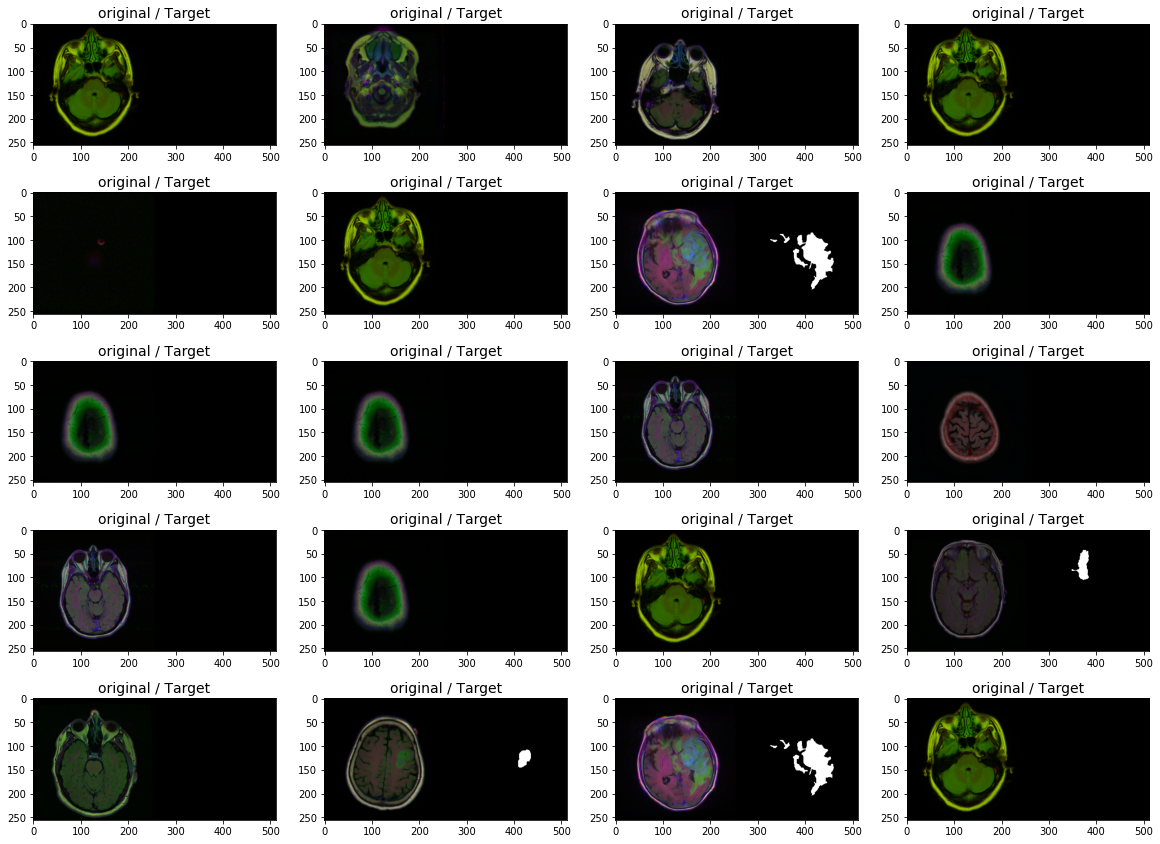

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

for ax in axes.flatten():
    plot_example(loader=test_loader, ax=ax, shape=shape)

In [38]:
def dice2(y_pred, y_true, eps=1e-7):
#     intersect = (y_pred * y_true).sum()
#     return 1 - 2 * (intersect + eps) / (y_pred.sum() + y_true.sum() + eps)

    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + eps) / (iflat.sum() + tflat.sum() + eps))

In [39]:
x = torch.tensor([0., 0., 0., 1., 1., 1., 0., 0.])
y = torch.tensor([0., 0., 1., 1., 1., 1., 1., 0.])
dice2(x, x), dice2(x, y)

(tensor(0.), tensor(0.2500))

In [41]:
def bce_dice(y_pred, y_true):
    dice_loss = dice2(y_pred, y_true)
    bce_score = nn.BCELoss()
    bce_loss = bce_score(y_pred, y_true)
    
#     return dice_loss + bce_loss
    return dice_loss

bce_dice(x, x), bce_dice(x, y)

(tensor(0.), tensor(0.2500))

In [45]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
    
    def forward(self, x):
#         print(1, x.shape)
        enc1 = self.encoder1(x)

        enc2 = self.encoder2(self.pool1(enc1))

        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        #print(dec1.shape)
        return torch.sigmoid(self.conv(dec1))
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "elu1", nn.ELU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "elu2", nn.ELU(inplace=True)),
                ]
            )
        )

In [42]:
def make_dirr(name):
    try:
        os.makedirs(name)
    except FileExistsError:
        pass

In [43]:
def train_model(model, optimizer, epochs, scheduler, train_data_loader, valid_data_loader, early_stopping=5, checkpoint_dirr=f'./checkpoint{1}/'):
    
    metrics = defaultdict(list)
    best_loss = np.inf
    
   
    early_count = 0
    
   
    make_dirr(checkpoint_dirr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        metric = 0
        scheduler.step()
        
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            for i, (images, target) in enumerate(tepoch):
                
                images = images.to(device)
                target = target.to(device) 
                
                
                optimizer.zero_grad()
                
              
                preds = model(images)
                
                
                loss = bce_dice(preds, target)
                
                
                loss.backward()
                
                
                optimizer.step()
                
               
                train_loss += loss.item()
                
                tepoch.set_postfix(loss=train_loss / (i + 1), lr=scheduler.get_lr()[0])
                
            metrics['loss'].append(train_loss / (i + 1))
            
        
        model.eval()
        
        sleep(0.1)

        with torch.no_grad():
            valid_loss = 0
            
            with tqdm(valid_data_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                for i, valid_batch in enumerate(tepoch):
                    valid_images, valid_target = valid_batch
                    valid_images = valid_images.to(device)
                    valid_target = valid_target.to(device)
                    
#                     valid_target = valid_target.long()

                    valid_preds = model(valid_images)

                    loss_valid = bce_dice(valid_preds, valid_target)

                    valid_loss += loss_valid.item()

                    tepoch.set_postfix(loss=valid_loss / (i + 1))

                metrics['val_loss'].append(valid_loss / (i + 1))

        sleep(0.1)
        
        if valid_loss < best_loss:
           
            best_loss = valid_loss

           
            early_count = 0

          
            torch.save(model.state_dict(), f'{checkpoint_dirr}epoch:{epoch}.pt')
        else:
            early_count += 1

            if early_count >= early_stopping:
                print(f"Loss did not improve over {early_stopping} epochs => early stopping")
                break

    return model, metrics, checkpoint_dirr

In [46]:

model = UNet().to(device)


optimizer = optim.Adam(model.parameters(), lr=0.12)

# model learning rate
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9)


epochs = 35

early_stopping = 8
    
model, losses, dirr = train_model(model=model, optimizer=optimizer, epochs=epochs, scheduler=scheduler, early_stopping=early_stopping,
                                  train_data_loader=train_loader, valid_data_loader=valid_loader)

Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.60batch/s, loss=0.24] 


In [47]:
model.load_state_dict(torch.load(f"{dirr}{[name for name in sorted(os.listdir(dirr)) if str(np.argmax(-np.array(losses['val_loss']))) in name][0]}"))
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1elu1): ELU(alpha=1.0, inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1elu2): ELU(alpha=1.0, inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2elu1): ELU(alpha=1.0, inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, mom

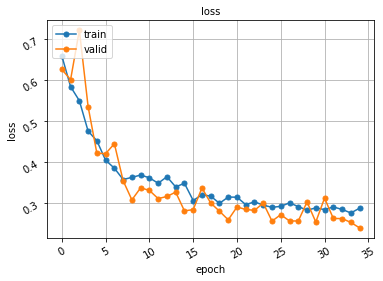

In [48]:
def graph_plot(history, typ=False):
    if typ:
        for i in history.keys():
            print(f'{i} = [{min(history[i])}; {max(history[i])}]\n')
    
    epoch = len(history['loss'])
    # на каждую: (train, val) + lr
    size = len(history.keys()) // 2 + 1

    ncols = 4
    nrows = int(np.ceil(size / ncols))

    
    fig = plt.figure(figsize=(27, 4))
    i = 1
    for k in list(history.keys()):
        if 'val' not in k:
            fig.add_subplot(nrows, ncols, i)
            plt.plot(history[k], marker='o', markersize=5)
            if k != 'lr':
                plt.plot(history['val_' + k], marker='o', markersize=5)
            plt.title(k, fontsize=10)

            plt.ylabel(k)
            plt.xlabel('epoch')
            plt.grid()

            plt.yticks(fontsize=10, rotation=30)
            plt.xticks(fontsize=10, rotation=30)
            plt.legend(['train', 'valid'], loc='upper left', fontsize=10, title_fontsize=15)
            i += 1
#         plt.show()

graph_plot(losses)


In [49]:
def plot_result(model, loader, ax, shape):
    images, target = next(iter(loader))
    ind = np.random.choice(range(loader.batch_size))
#     try:
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])
#     except IndexError:
#         images, target = next(iter(loader))
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])

    pred = model(images[ind].view(1, 3, shape, shape).to(device)).cpu().detach()[0].permute(1, 2, 0).reshape(shape, shape)
    loss = dice2(model(images[ind].view(1, 3, shape, shape).to(device)), target[ind].to(device))
    
    image = images[ind].permute(1, 2, 0)
    target = target[ind].permute(1, 2, 0).reshape(shape, shape)
    target = Image.fromarray(np.asarray(target * 255, dtype=np.uint8)).convert('RGB')
    pred = Image.fromarray(np.asarray(pred * 255, dtype=np.uint8)).convert('RGB')
    
    target = np.asarray(target)
    pred = np.asarray(pred)
    
    ax.imshow(np.hstack([image, target, pred]))
    ax.set_title(f'The original / Target / Forecast ; loss = {round(float(loss), 3)}', fontsize=14)

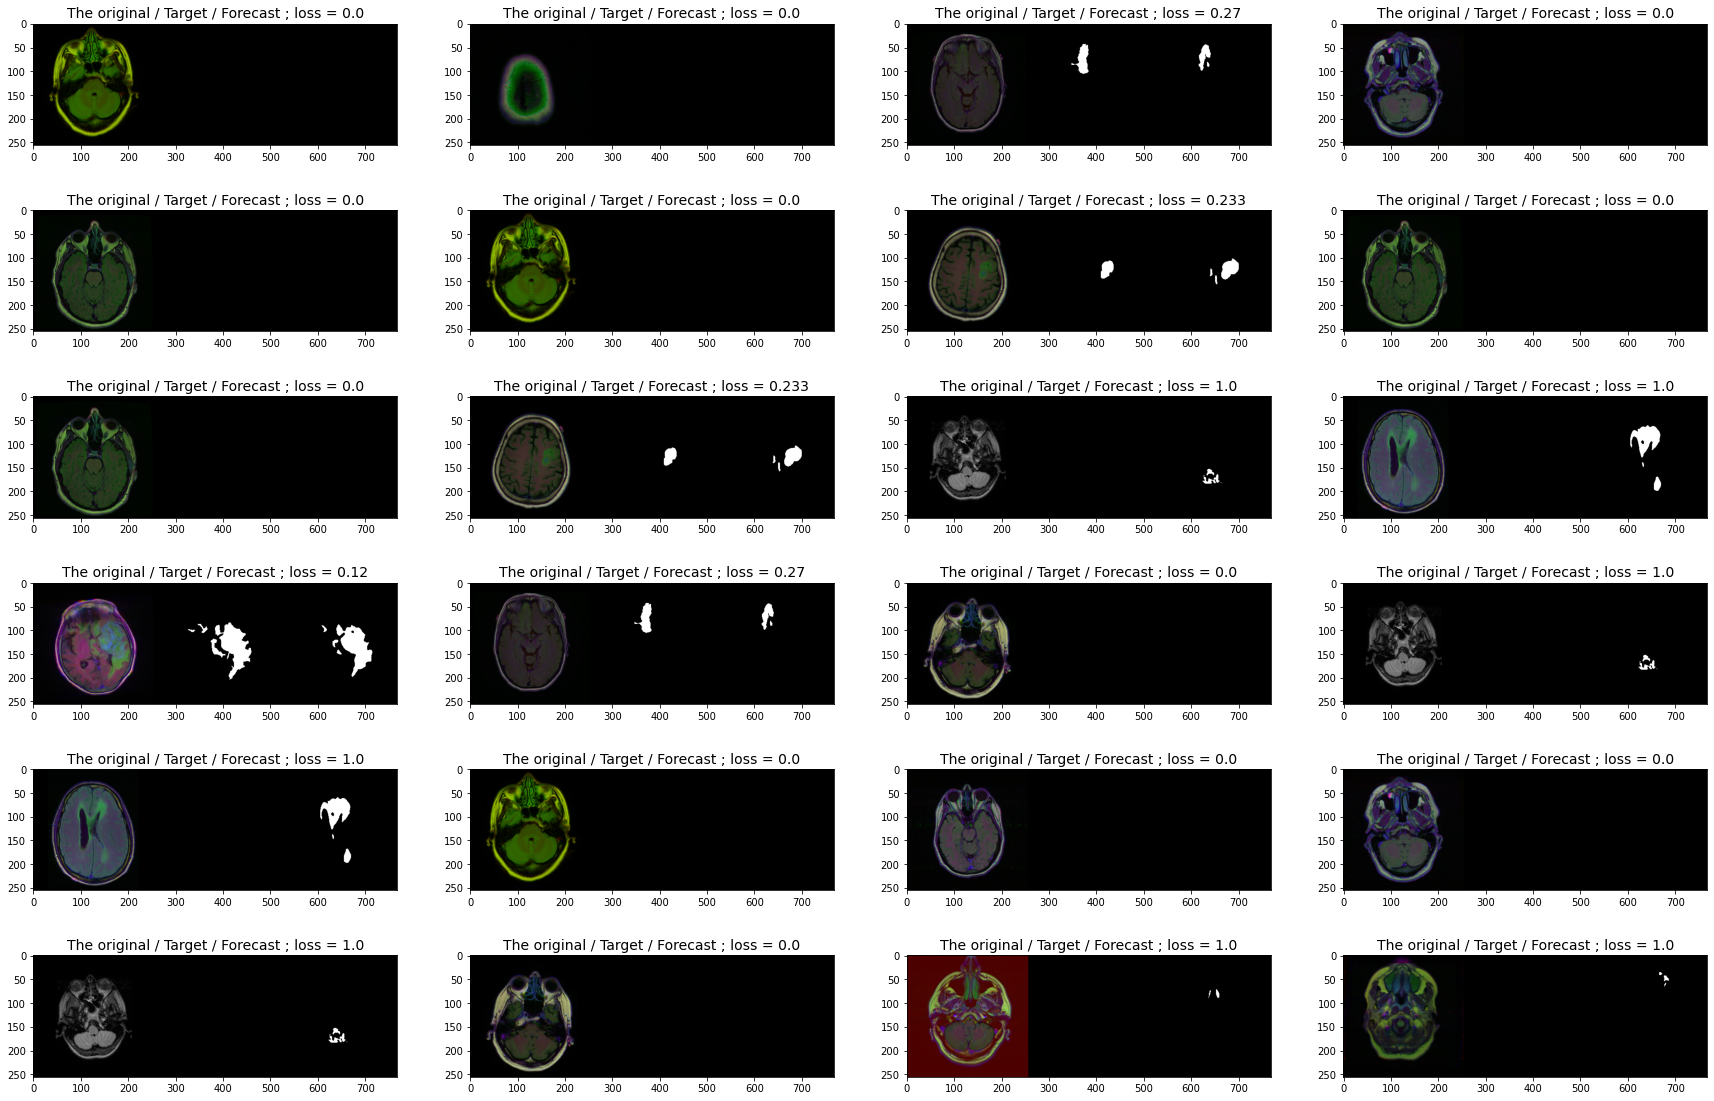

In [50]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30, 20))

for ax in axes.flatten():
    plot_result(model=model, loader=test_loader, shape=shape, ax=ax)